In [ ]:
# !pip install --user annoy

# Classification with DB

This code demonstrates the usage of the database as an object classification tool. 

## Load DB

In [1]:
from annoy import AnnoyIndex
import json

In [2]:
def load_class_to_indices(filename):
    with open(filename, "r") as f:
        return json.load(f)

In [3]:
# vector sizes for models
f_info_dict = {"resnet34": 512, "swin_transformer": 768}

In [4]:
db_file_path = "/Users/a1/Documents/GitHub/Pollen-Analyzer/Database/databases/pollen_db_resnet34.ann"
indx_class_filename = "/Users/a1/Documents/GitHub/Pollen-Analyzer/Database/databases/pollen_db_legend.json"
model_name = "resnet34"

In [5]:
f = f_info_dict[model_name]
u = AnnoyIndex(f, "euclidean")
if u.load(db_file_path):
    print("DB is loaded.")

DB is loaded.


In [6]:
loaded_class_to_indices = load_class_to_indices(indx_class_filename)
print(f"The database contains:")

index_to_class = {}
for class_name, indices in loaded_class_to_indices.items():
    print(f"{len(indices)} items of {class_name}")
    for idx in indices:
        index_to_class[idx] = class_name

The database contains:
42 items of Urtica
210 items of Populus tremula
113 items of Tilia
52 items of Poaceae
234 items of Salix
113 items of Plantago
316 items of Acer
242 items of Artemisia
99 items of Picea
146 items of Corylus
205 items of Betula
150 items of Chenopodiaceae
186 items of Fraxinus
131 items of Apiaceae
88 items of Quercus
73 items of Pinus
103 items of Alnus
98 items of Rumex


## Classification

In [7]:
import torch
import os
import torchvision.models as models
import torchvision.transforms as transforms
from glob import glob
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image

### Load model and get feature extractor

In [8]:
def get_feature_extractor(model):
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    return feature_extractor

In [9]:
models_dict = {
    "resnet34": models.resnet34(weights="DEFAULT"),
    "swin_transformer": models.swin_t(weights="DEFAULT"),
}

In [10]:
model = models_dict[model_name]
feature_extractor = get_feature_extractor(model)

### Load test images

In [11]:
input_dir = "/Users/a1/Documents/GitHub/Pollen-Analyzer/data"
test_images = glob(os.path.join(input_dir, "*.png"))
print(f"{len(test_images)} test images are loaded.")

9 test images are loaded.


### Get predictions

In [12]:
def get_class(db: AnnoyIndex, vector, index_to_class: dict, k: int = 5):
    neighbor_ids = db.get_nns_by_vector(vector, k, include_distances=False)
    
    neighbor_classes = [index_to_class[neighbor_id] for neighbor_id in neighbor_ids]
    most_common_class = Counter(neighbor_classes).most_common(1)[0][0]
    return most_common_class

In [13]:
preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


def extract_features(img_path: str, feature_extractor):
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        features = feature_extractor(img_tensor)
    return features.squeeze().numpy()

In [14]:
def plot_pred(imgs, labels, ax_title: bool = True):
    num_rows = 1
    num_cols = len(imgs)
    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        squeeze=False,
        figsize=(num_cols * 3, num_rows * 5),
    )
    for col_idx, img in enumerate(imgs):
        ax = axs[0][col_idx]
        img = Image.open(imgs[col_idx])
        ax.imshow(img)
        if ax_title:
            ax.set_title(labels[col_idx])
    plt.show()

In [15]:
def get_test_pred(
    test_images: list, db: AnnoyIndex, index_to_class: dict, model, k: int
):
    pred = []
    for image_path in tqdm(test_images):
        vector = extract_features(image_path, model)
        pred.append(get_class(db, vector, index_to_class, k))

    plot_pred(test_images, pred)


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 41.33it/s]


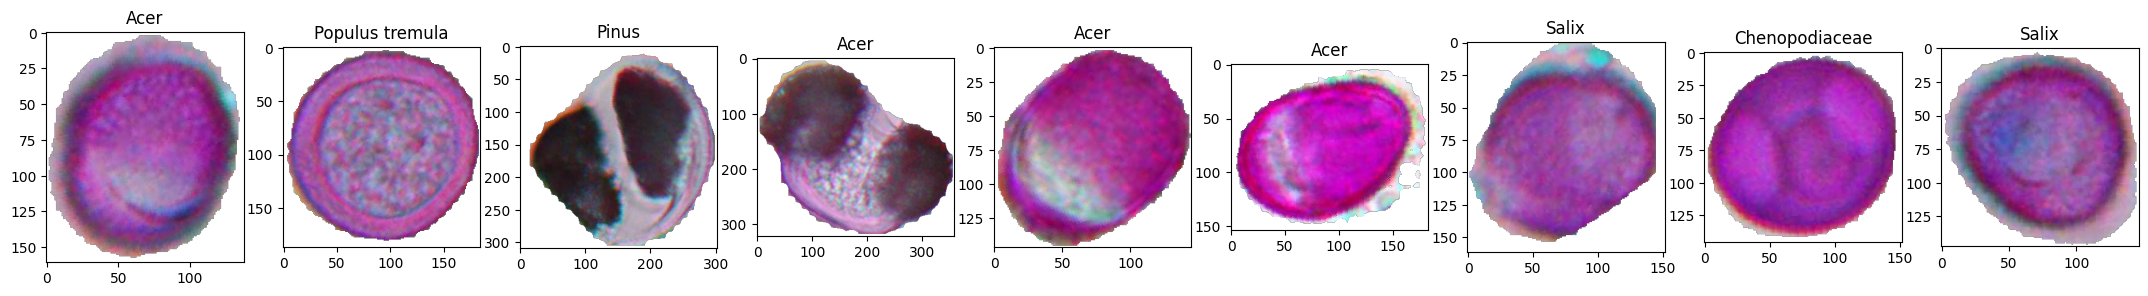

In [16]:
k = 10  # knn
get_test_pred(test_images, u, index_to_class, feature_extractor, k)